STEP 1:IMPORTING THE LIBRARIES: 

Importing the necessary libraries to be used in this project

In [237]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scipy.stats import randint
from joblib import dump, load
from skimage import color, exposure, transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [238]:
# # Function to load images from a directory and its subdirectories
# def load_images_from_folder(Potato):
#     images = []
#     labels = []
#     for root, _, files in os.walk(Potato):
#         for filename in files:
#             if filename.endswith(".JPG"):
#                 Train = os.path.basename(root)  # Use the subfolder name as the label
#                 img = Image.open(os.path.join(root, filename))
#                 if img is not None:
#                     images.append(np.array(img))
#                     labels.append(Train)
#                 else:
#                     print(f"Error loading image: {os.path.join(root, filename)}")
#     return np.array(images), np.array(labels)

In [239]:
# Function to preprocess images
def preprocess_img(img, target_features=16384):
    # Resize image to the required dimensions (128*128)
    img_resized = transform.resize(img, (128, 128), anti_aliasing=True, preserve_range=True)

    # Convert to RGB if the image has a single channel
    if len(img_resized.shape) == 2:
        img_rgb = np.stack([img_resized] * 3, axis=-1)
    else:
        img_rgb = img_resized

    # Reshape the image to (128, 128, 3)
    img_reshaped = np.reshape(img_rgb, (128, 128, 3))

    # Flatten the image
    img_flattened = img_reshaped.flatten()

    # Reshape the flattened image to the target number of features
    img_output = np.reshape(img_flattened, (-1, target_features))

    return img_output

STEP 2: SETTING THE PATH TO THE DATASET AND LADING THE IMAGES AND LABELS IN THE FOLDERS OF THE DATASET

In [240]:
# Set the path to the downloaded dataset on the desktop
dataset_path = os.path.expanduser("C:/Users/ezeki/Desktop/project/Potato")

In [241]:
# Assuming your dataset is structured in folders train, test, and validate
train_folder = os.path.join(dataset_path, 'Train')
test_folder = os.path.join(dataset_path, 'Test')
validate_folder = os.path.join(dataset_path, 'Valid')

In [242]:
# Load images and labels for training, testing, and validation
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)
X_validate, y_validate = load_images_from_folder(validate_folder)

In [243]:
# Check if any images were loaded
if len(X_train) == 0 or len(X_test) == 0 or len(X_validate) == 0:
    raise ValueError("No images loaded. Check the file paths and the load_images_from_folder function.")

STEP 3: PREPROCESSING IMAGES

In [244]:
# Preprocess images
X_train_preprocessed = np.array([preprocess_img(x) for x in X_train])
X_train_flat = X_train_preprocessed.reshape(X_train_preprocessed.shape[0], -1)

X_test_preprocessed = np.array([preprocess_img(x) for x in X_test])
X_test_flat = X_test_preprocessed.reshape(X_test_preprocessed.shape[0], -1)

X_validate_preprocessed = np.array([preprocess_img(x) for x in X_validate])
X_validate_flat = X_validate_preprocessed.reshape(X_validate_preprocessed.shape[0], -1)

In [245]:
# Check the shape of the training data
print("Shape of training data (X_train_flat):", X_train_flat.shape)

Shape of training data (X_train_flat): (456, 49152)


STEP 4: CONVERTING THE IMAGES IN THE DATASET TO CSV FORMAT, LOADING THE IMAGES AND READ THE IMAGES CONVERTED

In [246]:
#Check if the CSV file already exists
train_csv_path = 'train_images.csv'
test_csv_path = 'test_images.csv'
validate_csv_path = 'validate_images.csv'

if not os.path.isfile(train_csv_path):
    train_data = pd.DataFrame(X_train_flat)
    train_data['label'] = y_train
    train_data.to_csv(train_csv_path, index=False)
    print("Train images CSV file saved successfully")
else:
    print("Train images CSV file already exists.")

if not os.path.isfile(test_csv_path):
    test_data = pd.DataFrame(X_test_flat)
    test_data['label'] = y_test
    test_data.to_csv(test_csv_path, index=False)
    print("Test images CSV file saved successfully")
else:
    print("Test images CSV file already exists.")

if not os.path.isfile(validate_csv_path):
    validate_data = pd.DataFrame(X_validate_flat)
    validate_data['label'] = y_validate
    validate_data.to_csv(validate_csv_path, index=False)
    print("Validate images CSV file saved successfully")
else:
    print("Validate images CSV file already exists.")

Train images CSV file already exists.
Test images CSV file already exists.
Validate images CSV file already exists.


In [247]:
# Load images and labels from the CSV file
train_csv_path = 'train_images.csv'
test_csv_path = 'test_images.csv'
validate_csv_path = 'validate_images.csv'

In [248]:
# Read the CSV files and plot images
train_images_csv = pd.read_csv(train_csv_path)
test_images_csv = pd.read_csv(test_csv_path)
validate_images_csv = pd.read_csv(validate_csv_path)

In [249]:
X_train_flat = train_images_csv.iloc[:, :-1].values
y_train = train_images_csv['label'].values

In [250]:
X_test_flat = test_images_csv.iloc[:, :-1].values
y_test = test_images_csv['label'].values

In [251]:
X_validate_flat = validate_images_csv.iloc[:, :-1].values
y_validate = validate_images_csv['label'].values

STEP 5: SPLITTING THE DATA INTO TRAINING AND VALIDATION SETS

In [252]:
X_train_split, X_validate_split, y_train_split, y_validate_split = train_test_split(
    np.concatenate([X_train_flat, X_validate_flat]),
    np.concatenate([y_train, y_validate]),
    test_size=0.2,
    random_state=42,
    stratify=np.concatenate([y_train, y_validate])
)

STEP 6: MODEL TRAINING

In [253]:
# Feature scaling
scaler = StandardScaler()
if len(X_train_flat) > 0:
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.fit_transform(X_test_flat)
    X_validate_scaled = scaler.fit_transform(X_validate_flat)

In [254]:
# Define the parameter grid for grid search
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l2', 'l1', 'elasticnet'],
              'max_iter': [1000, 2000, 3000],
              'tol': [1e-3, 1e-4, 1e-5]}

In [255]:
# Initialize SVM classifier
svm_classifier = SGDClassifier(loss='hinge', random_state=42)

In [215]:
# Define the stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [216]:
# Perform grid search with stratified cross-validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid,
                           cv=stratified_cv, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [1000, 2000, 3000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.001, 0.0001, 1e-05]})

In [217]:
# Use the best estimator to predict on the validation data
y_pred = grid_search.best_estimator_.predict(X_validate_scaled)

In [256]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'alpha': 1, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}


In [257]:
# Use the best hyperparameters to train the final model
best_svm_classifier = grid_search.best_estimator_
best_svm_classifier.fit(X_train_scaled, y_train)

SGDClassifier(alpha=1, random_state=42)

In [258]:
# Use the best hyperparameters to train the final model
#best_svm_classifier = SVC(**best_params, random_state=42)
#best_svm_classifier.fit(X_train_scaled, y_train)

In [259]:
# Calculate accuracy on the test set
best_svm_classifier = grid_search.best_estimator_
y_pred_test = best_svm_classifier.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test set accuracy: {accuracy_test*100:.2f}%")

Test set accuracy: 96.25%


STEP 7: EVALUATE METRICS. CLASSIFICATION REPORT, CONFUSION MATRIX, ROC AND AUC.

In [260]:
#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.91      1.00      0.95        60
 Potato___Late_blight       1.00      0.94      0.97       100

             accuracy                           0.96       160
            macro avg       0.95      0.97      0.96       160
         weighted avg       0.97      0.96      0.96       160



In [261]:
# Predictions on the validation set
y_pred_validate = best_svm_classifier.predict(X_validate_scaled)

In [262]:
# Calculate accuracy on the validation set
accuracy_validate = accuracy_score(y_validate, y_pred_validate)
print(f"Validation set accuracy: {accuracy_validate*100:.2f}%")

Validation set accuracy: 76.72%


In [263]:
# Calculate overall accuracy
y_true = np.concatenate([y_train, y_test, y_validate])
y_pred = np.concatenate([best_svm_classifier.predict(X_train_scaled), y_pred_test, y_pred_validate])
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall accuracy: {overall_accuracy*100:.2f}%")

Overall accuracy: 95.49%


In [264]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

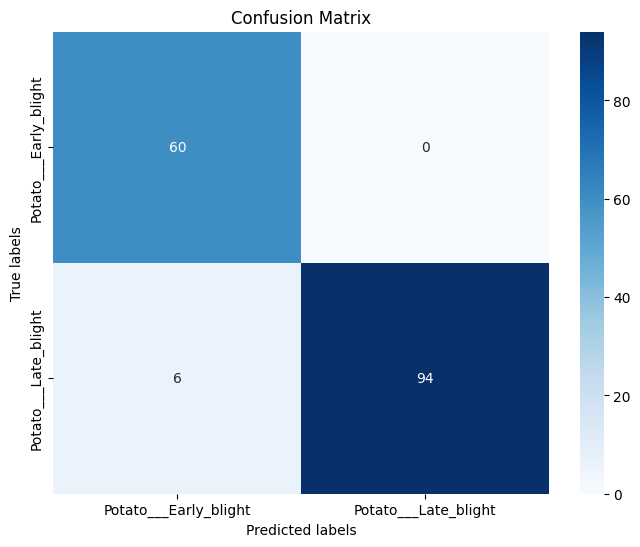

In [265]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [266]:
# Convert string labels to binary numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

In [267]:
# Calculate the probabilities for each class
y_scores = best_svm_classifier.decision_function(X_test_scaled)

In [268]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_scores)

In [269]:
# Calculate the AUC
roc_auc = roc_auc_score(y_test_encoded, y_scores)

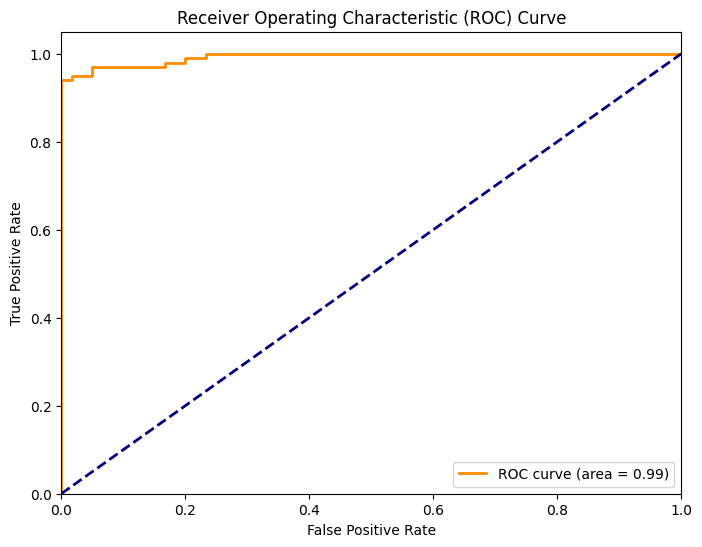

In [270]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

STEP 8: SAVING THE MODEL

In [271]:
# Save the model to a file
dump(best_svm_classifier, 'potato_model.pkl')

['potato_model.pkl']